In [1]:
import torch
from nisrep.normalizing_flows.manager import *
from nisrep.PhaseSpace.flat_phase_space_generator import *
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import torch.multiprocessing as mp
from mpl_toolkits.mplot3d import Axes3D
import vegas
import time
import datetime
from inspect import getsourcefile
from os.path import abspath
import lhapdf
torch.set_default_dtype(torch.double)
#torch.pow(torch.tensor(torch.ones(1,1)),4)
"""
lhapdf.pathsPrepend("/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3/HEPTools/lhapdf6/share/LHAPDF")
p = lhapdf.mkPDF("NNPDF23_nlo_as_0119/0")
pset = lhapdf.getPDFSet("NNPDF23_nlo_as_0119")
print("----")
print(pset.description)
print("---")
#import scs
"""
root_path = '/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop'
hyperparameter_path='/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/LTD/hyperparameters.yaml'
topologies_path='/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/LTD/topologies.yaml'
amplitudes_path='/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/LTD/amplitudes.yaml'
name='P0L1R1'
name2='/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/TEST_epem_a_ddx/FORM/Rust_inputs/P0L1R1.yaml'
sys.path.insert(0, root_path)
#root_path2 = '/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/scs/out'
#sys.path.insert(0, root_path2)
#from libscsdir import *
#print(sys.path)
start_time=datetime.datetime.utcnow()
E_cm  = 1000.0
w = torch.empty(40000, 8)
torch.nn.init.uniform_(w) 
mass=100
my_PS_generator=FlatInvertiblePhasespace([mass]*2, [mass + 0.*i for i in range(4)],
                                            pdf=None,pdf_active=False)
momenta, wgt = my_PS_generator.generateKinematics_batch(E_cm, w,pT_mincut=0,
                                                            delR_mincut=0, rap_maxcut=-1,pdgs=[2,-1])
end_time=datetime.datetime.utcnow()
print((end_time-start_time).total_seconds())
print(torch.max(torch.abs(momenta[:,1,0]+momenta[:,0,0]-(momenta[:,2,0]+momenta[:,3,0]+momenta[:,4,0]+momenta[:,5,0]))))
print(torch.max((momenta[:,1,3]+momenta[:,0,3])-(momenta[:,2,3]+momenta[:,3,3]+momenta[:,4,3]+momenta[:,5,3])))
#print(torch.max((momenta[:,2,3]+momenta[:,3,3]+momenta[:,4,3]+momenta[:,5,3])))
#print(momenta)
print(torch.mean(wgt)/torch.max(wgt))
lr=torch.ones(1)
print((10*torch.ones(1))**lr.uniform_(-5,-2))

1.24573
tensor(4.5475e-13)
tensor(0.)
tensor(0.0771)
tensor([0.0001])


In [2]:
def step(x):
    a=torch.zeros_like(x[:,0])
    b=torch.ones_like(x[:,0])
   
    return torch.where(torch.max(abs(x[:,0]), abs(x[:,1]))>1,a,b)

def sq(x):
    
    ret=(2*x[:,0]-1)**2
    
    return ret

def g(x): #box: expect 0.25 in dim2
   
    q=torch.max(torch.abs(x),dim=-1).values
  
    a=torch.zeros_like(q)
    b=torch.ones_like(q)
   
    return torch.where(q<0.5,a,b)

def gaussian(x):
    return torch.exp( -((x[:,0]-0.5)**2+(x[:,1]-0.5)**2)/(0.3**2)) 

def gaussiannp(x):
    return np.exp( -((x[:,0]-0.5)**2+(x[:,1]-0.5)**2)/(0.3**2))

def gaussianveg(x):
    return np.exp( -((x[0]-0.5)**2+(x[1]-0.5)**2)/(0.3**2))


def camelnp(x):
    return np.exp( -((x[:,0]-0.75)**2+(x[:,1]-0.75)**2)/(0.2**2))+np.exp( -((x[:,0]-0.25)**2+(x[:,1]-0.25)**2)/(0.2**2))

def camelveg(x):
    return np.exp( -((x[0]-0.75)**2+(x[1]-0.75)**2)/(0.2**2))+np.exp( -((x[0]-0.25)**2+(x[1]-0.25)**2)/(0.2**2))


def camel(x):
    return torch.exp( -((x[:,0]-0.75)**2+(x[:,1]-0.75)**2)/(0.2**2))+torch.exp( -((x[:,0]-0.25)**2+(x[:,1]-0.25)**2)/(0.2**2))

def gaussianb(x):
    return torch.exp( -(x)**2)[:,0]

def gaussianbnp(x):
    return np.exp( -((x[:,0]+1)**2+(x[:,1])**2) )



def con(x):
    y=torch.empty(x.shape[0])
    return y.fill_(5)

def sin(x):
    return 2+torch.sin(x[:,1])

def lin(x):
    return 0.2*x[:,0]+0.5

def sinnp(x):
    return 2+np.sin(x[:,1])

def tanp(r):
    return (1+((torch.tan((r-0.5)*np.pi))**2))*np.pi

def vegastest(x):
    gw=0.15
    shift=np.ones_like(x)*0.25
    shift1=shift.copy()*3
    lim=int((shift.shape[1]/2))
    shift2=np.concatenate((shift[:,:lim],shift1[:,lim:]),-1)
    shift3=np.concatenate((shift1[:,:lim],shift[:,lim:]),-1)
    return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))



def create_fun(gn, gw):
    
    if(gn==1):
        def f(x):
                return torch.exp(-torch.sum((x-0.5)**2/(gw**2),-1))
        return f
    
    if(gn==2):
        def f(x):
                return torch.exp(-torch.sum((x-0.25)**2/(gw**2),-1))+torch.exp(-torch.sum((x-0.75)**2/(gw**2),-1))
        return f
    
    if(gn==4):
        def f(x):
            shift=torch.ones_like(x)*0.25
            shift1=shift.clone()*3
            lim=int((shift.shape[1]/2))
            shift2=torch.cat((shift[:,:lim],shift1[:,lim:]),-1)
            shift3=torch.cat((shift1[:,:lim],shift[:,lim:]),-1)
            return torch.exp(-torch.sum((x-shift)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift1)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift2)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift3)**2/(gw**2),-1))
        return f
    
    if(gn==8):
        def f(x):
            shift=torch.ones_like(x)*0.25#000
            shift1=shift.clone()*3#111
            lim=int((shift.shape[1]/3))
            shift2=torch.cat((shift[:,:lim],shift1[:,lim:2*lim],shift[:,2*lim:]),-1) #010
            shift3=torch.cat((shift1[:,:lim],shift[:,lim:]),-1)#100
            shift4=torch.cat((shift1[:,:lim],shift1[:,lim:2*lim],shift[:,2*lim:]),-1) #110
            shift5=torch.cat((shift[:,:2*lim],shift1[:,2*lim:]),-1) #001
            shift6=torch.cat((shift1[:,:lim],shift[:,lim:2*lim],shift1[:,2*lim:]),-1) #101
            shift7=torch.cat((shift[:,:lim],shift1[:,lim:]),-1) #011
            return torch.exp(-torch.sum((x-shift)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift1)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift2)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift3)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift4)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift5)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift6)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift7)**2/(gw**2),-1))
        return f
    
def create_funv(gn, gw):
    
    if(gn==1):
        def f(x):
                return np.exp(-np.sum((x-0.5)**2/(gw**2),-1))
        return f # peak at [0.5,...,0.5]
    
    if(gn==2):
        def f(x):
                return np.exp(-np.sum((x-0.25)**2/(gw**2),-1))+np.exp(-np.sum((x-0.75)**2/(gw**2),-1))
        return f  #peak at [0.25,...,0.25] and [0.75,...,0.75]
    
    if(gn==4):
        
        def f(x):
            shift=np.ones_like(x)*0.25
            shift1=shift.copy()*3
            lim=int((shift.shape[0]/2))
            shift2=np.concatenate((shift[:lim],shift1[lim:]),-1)
            shift3=np.concatenate((shift1[:lim],shift[lim:]),-1)
            return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))
        return f #peak at [0.25,...,0.25], [0.75,...,0.75],[0.25,...,0.75], [0.25,...,0.75]
                #in dim2, there would be in the [0,1] plane only two peaks, as two are identical
                # other than gn=2, the [1,2] plane has 4 peaks
              
    
    if(gn==8):
        
        def f(x):
            shift=np.ones_like(x)*0.25#000
            shift1=shift.copy()*3#111
            lim=int(shift.shape[0]/3)
            shift2=np.concatenate((shift[:lim],shift1[lim:2*lim],shift[2*lim:]),0) #010
            shift3=np.concatenate((shift1[:lim],shift[lim:]),0)#100
            shift4=np.concatenate((shift1[:lim],shift1[lim:2*lim],shift[2*lim:]),0) #110
            shift5=np.concatenate((shift[:2*lim],shift1[2*lim:]),0) #001
            shift6=np.concatenate((shift1[:lim],shift[lim:2*lim],shift1[2*lim:]),0) #101
            shift7=np.concatenate((shift[:lim],shift1[lim:]),0) #011
            return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))+ np.exp(-np.sum((x-shift4)**2/(gw**2),-1))+np.exp(-np.sum((x-shift5)**2/(gw**2),-1))+np.exp(-np.sum((x-shift6)**2/(gw**2),-1))+np.exp(-np.sum((x-shift7)**2/(gw**2),-1))
        return f #here, in [0,1] plane there are actually 4 peaks

In [3]:

E_cm  = 1000.0
 
mass=10
my_PS_generator=FlatInvertiblePhasespace([mass]*2, [mass + 0.*i for i in range(2)],
                                           pdf=None,pdf_active=False)
#n_flow = my_PS_generator.nDimPhaseSpace() # number of dimensions
n_flow=2
#my_PS_generator.get_dimensions()
# We define our NormalizingFlow object 

NF =  PWQuadManager(n_flow=n_flow)
NF.create_model(2,4, [3]*3,0)
#print(NF._model)
w = torch.empty(20000, NF.n_flow)
#NF._model(NF.format_input(w,NF._model.device))

In [4]:
pjoin = os.path.join
os.environ['LD_LIBRARY_PATH']=":"+root_path+"/libraries/fjcore:"+root_path+"/libraries/ecos:"+root_path+"/libraries/scs/out:"+root_path+"/libraries/Cuba-4.2"
#print(sys.path)
print(os.environ['LD_LIBRARY_PATH'])
os.environ['LD_LIBRARY_PATH']=":/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/fjcore:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/ecos:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/scs/out:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/Cuba-4.2"
print(os.environ['LD_LIBRARY_PATH'])
if not os.path.exists('stats'):
        os.mkdir('stats')
from ltd import LTD, CrossSection
os.environ['MG_NUMERATOR_PATH']='/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/TEST_epem_a_ddx'
rust_instances=[]

rust_instance = CrossSection(
            name2,hyperparameter_path
        )
rust_instances.append(rust_instance)
momenta_input=torch.empty(1, NF.n_flow)
torch.nn.init.uniform_(momenta_input)
momenta, wgt = my_PS_generator.generateKinematics_batch(E_cm, momenta_input,pT_mincut=10,
                                                            delR_mincut=0.9, rap_maxcut=2.4,pdgs=[2,-1])
momenta_input=momenta.squeeze(0).cpu().tolist()

#momenta_input = [ [0.0]+[ki for ki in k] for k in momenta_input ]
print(momenta_input)
res_re, res_im = rust_instances[-1].evaluate(momenta_input)
print({'res':res_re+res_im*1j})
#:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/fjcore:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/ecos:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/scs/out:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/Cuba-4.2


:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/fjcore:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/ecos:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/scs/out:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/Cuba-4.2
:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/fjcore:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/ecos:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/scs/out:/home/niklas/Desktop/Thesis_code/MG5_aMC_v3_0_2_py3_2/PLUGIN/alphaloop/libraries/Cuba-4.2


ImportError: libscsdir.so: cannot open shared object file: No such file or directory

In [5]:

#NF.create_model(n_cells=2, n_bins=10, NN=[10,10,10,10,10],dev=torch.device("cpu")) 
NF.create_model(n_cells=2, n_bins=10, NN=[11,11,11],dev=torch.device("cpu"))
optim = torch.optim.Adamax(NF._model.parameters(),lr=2e-3, weight_decay=1e-04) 
#NF.create_model(n_cells=2, n_bins=7, NN=[11,11,11,11,11],dev=torch.device("cpu"))
#optim = torch.optim.Adamax(NF._model.parameters(),lr=2e-3, weight_decay=5e-07)

def massive_bhabha_full(momenta, mass):
    m4=mass**4
    m2=mass**2
    reg=1
    ab=dot_t(momenta[:,0,:],momenta[:,1,:])
    
    bc=dot_t(momenta[:,1,:],momenta[:,2,:])
    cd=dot_t(momenta[:,2,:],momenta[:,3,:])
    ac=dot_t(momenta[:,0,:],momenta[:,2,:])
    ad=dot_t(momenta[:,0,:],momenta[:,3,:])
    bd=dot_t(momenta[:,1,:],momenta[:,3,:])
    terma=(ad**2+ab**2-2*m2*(bd)+2*m4)/(square_t(momenta[:,1,:]-momenta[:,3,:])**2+reg) 
    
    termb=(ad**2+bd**2-2*m2*(ab)+2*m4)/(square_t(momenta[:,1,:]+momenta[:,0,:])**2)

    termc=(ad**2+8*m2+(ab+bd-ad)+8*m4)/(square_t(momenta[:,1,:]+momenta[:,0,:])*square_t(momenta[:,1,:]-momenta[:,3,:])-reg)
    #needs still regularization
    
    return 16*(terma+termb+2*termc)
def phase_spawn(x):
    
    momenta, wgt = my_PS_generator.generateKinematics_batch(E_cm, x,pT_mincut=10,
                                                            delR_mincut=0.9, rap_maxcut=2.4,pdgs=[2,-1])
    
    """
    print("----")
    print(torch.sum(momenta[:,2:,0],axis=1))
    print(torch.sum(momenta[:,:2,0],axis=1))
    print("-----")
    print("----")
    print(torch.sum(momenta[:,2:,1],axis=1))
    #print(torch.sum(momenta[:,:2,0],axis=1))
    print("-----")
    print("----")
    print(torch.sum(momenta[:,2:,2],axis=1))
    #print(torch.sum(momenta[:,:2,0],axis=1))
    print("-----")
    print("----")
    print(torch.sum(momenta[:,2:,3],axis=1))
    print(torch.sum(momenta[:,:2,3],axis=1))
    print("-----")
    
    print(momenta)
    
    """
    s=square_t((momenta[:,0,:]+momenta[:,1,:]))
    
    t=square_t((momenta[:,0,:]-momenta[:,2,:]))
    
    u=square_t((momenta[:,0,:]-momenta[:,3,:]))
   # print(max(t))
    mw=91.2
    gammaw=2.5
    reg=0.00
    #mass=0
    ### not good###
    #ret=((1/(64*(math.pi**2)*s)*2*(t**2+u**2)/((mw**2-s)**2)))*4*math.pi #nu+nu -> Z -> nu+nu, massless,has to be done with E<<90
    #ret=((1/(64*(math.pi**2)*s)*2*(s**2+u**2)/((mw**2-t)**2)))*4*math.pi #e^-mu^- -> Z -> mu^-e^-, massless,
    
    
    
   
    #############
    #----
    #Pair production (=annihilation process=s-channel) #not included: scattering
    #ret=((torch.sqrt((e-1000**2)/e)*(T/(4*s**2))/(256*math.pi**2*e))*4*math.pi)   #e⁺e⁻->gamma->e⁺e⁻, massive
    
    #ret=((1/(64*(math.pi**2)*s)*2*(t**2+u**2)/(s**2)))*4*math.pi #e⁺e⁻->gamma->e⁺e⁻, massless
    ret5=((t**2+u**2)/(s**2))*4*np.pi*(1/132.5)**2*(1/s)*2*(16/64)# (same but different expression/constants, includes 3)
  
    
   
    #print(torch.mean(2*(t**2+u**2)/(s**2)))
    #same quality as VEGAS

    #ret=(1/(64*math.pi**2*s))*massive_bhabha_full(momenta, mass)*4*math.pi
    #seems to be still instable, but works with vegas; vegas seems more tolerant to peaks, needs less regularization
    #maybe improvable with more statistics and slower training, or the old problem again
    #needs regularization of O(1); vegas can perform better with small regularization, generally a bit worse than 
    #VEGAS
    
    #------
    #these  all work, but they have basically the same result as they are almost the same processes
    #their reduction is of the same order of mag as for VEGAS
   # print(torch.isnan(wgt).any())
    #print(torch.isnan(ret5).any())
    return ret5*wgt

w = torch.empty(20000, NF.n_flow)
torch.nn.init.uniform_(w)
print("result")
s=phase_spawn(w)
print(torch.mean(s))
print(torch.min(s))
#print(torch.isnan(s).any())
#print(torch.mean(s).is_nan())
#print(0*np.nan)
#does the thing with lhapdf work? we throw tensors inside! -> have not used pdfs yet, gave 0,0
#check mean of pdf -> get u/d value
#all a bit too small. problem with jac? or with 1/x? probably jac

result
tensor(4.6301e-18)
tensor(0.)


In [6]:
def c(x):
    return (1/200000)*torch.cos((x[:,0]-0.5)*math.pi)**8
#f=phase_spawn
f=create_fun(2,0.25)
start_time=datetime.datetime.utcnow()
sig, sig_err=NF._train_variance_forward_seq(f,optim,"./logs/tmp/",10000,300,0,True, True,None,0,True, integrate=True,preburn_time=50)
end_time=datetime.datetime.utcnow()
print(sig)
print(sig_err)
#print(sig/(2.56819*10**(-9)))
print((end_time-start_time).total_seconds())

#why does DKL give no improvement? dkl improves if variance improves
#2D-2: benchmark 0.05

tensor(0.0556)
tensor(0.0006)
0.05553458115302111
0.0003119234217022327
339.046774


In [7]:
w = torch.empty(50000, NF.n_flow)
torch.nn.init.uniform_(w)
dkl=torch.nn.KLDivLoss(reduction='batchmean')
Y=NF.format_input(w, dev=torch.device("cpu"))
X=NF.best_model(Y)
print('Initial loss')
print(NF.int_loss)
print('Initial dkl')
#print(f(w).shape)
#print(w.shape)
print(dkl(torch.log((f(w)+torch.ones_like(f(w)).fill_(1e-45))),w[:,0]))
print(NF.best_epoch)
print('Best loss')
print(NF.best_loss)
print('Best loss relative')
print(NF.best_loss_rel)
print('Final dkl')
print(dkl(torch.log((f(X[:,:-1])*X[:,-1])+torch.ones_like(f(w)).fill_(1e-45)),w[:,0]).detach())
print('Actual variance reduction')
red=torch.var(f(X[:,:-1])*X[:,-1])/torch.var(f(w))
print(red)
print('Function evaluations')
print(NF.best_func_count)
print('loss_estimator_var')
print(NF.best_var) 
print(X[:,-1])



w = torch.empty(2000, NF.n_flow)
torch.nn.init.uniform_(w)

XJ=NF.model(NF.format_input(w,dev=w.device))
X=XJ[:,:-1]
print("old variance")
print(torch.var(phase_spawn(w)))
print("new variance")
print(torch.var(phase_spawn(X)*XJ[:,-1]))

print(torch.mean(phase_spawn(X)*XJ[:,-1]))

Initial loss
tensor(0.0162)
Initial dkl
tensor(2.5187)
133
Best loss
tensor(0.0084, grad_fn=<DivBackward0>)
Best loss relative
tensor(0.5186, grad_fn=<DivBackward0>)
Final dkl
tensor(1.8678)
Actual variance reduction
tensor(0.7161, grad_fn=<DivBackward0>)
Function evaluations
9640000.0
loss_estimator_var
6.756402502275151e-05
tensor([0.1289, 1.7978, 0.0158,  ..., 1.7886, 0.1867, 1.8619],
       grad_fn=<SelectBackward>)
old variance


AssertionError: 

In [7]:

w = torch.empty(40, NF.n_flow)
torch.nn.init.uniform_(w)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w,torch.device("cpu")))

#print("mapped")
#print(NF.format_input(100*torch.tan((w-0.5)*(np.pi))))
XJ=NF.model(NF.format_input(w,torch.device("cpu")))


                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian

XJ2=NF.best_model(NF.format_input(w,torch.device("cpu")))


                    # Separate the points and their Jacobians:
print("XJ2")
print(XJ2)



W
tensor([[0.2931, 0.7449, 0.8323, 0.7003, 0.3071, 0.1219, 0.2894, 0.9244, 0.8527],
        [0.4333, 0.1965, 0.9032, 0.2409, 0.1440, 0.4739, 0.5636, 0.1243, 0.5291],
        [0.1303, 0.8211, 0.6097, 0.6419, 0.7656, 0.6715, 0.0108, 0.4581, 0.3620],
        [0.4766, 0.7157, 0.9947, 0.6680, 0.7590, 0.6508, 0.8921, 0.6058, 0.5823],
        [0.5622, 0.0626, 0.7437, 0.7558, 0.9818, 0.7471, 0.7714, 0.1849, 0.2349],
        [0.2690, 0.8410, 0.0729, 0.2485, 0.8698, 0.2793, 0.1064, 0.0060, 0.2264],
        [0.6164, 0.6616, 0.2897, 0.0160, 0.9148, 0.0022, 0.9536, 0.0840, 0.8905],
        [0.5277, 0.1665, 0.6026, 0.5618, 0.3413, 0.9046, 0.1694, 0.7730, 0.5470],
        [0.8825, 0.5861, 0.9350, 0.4255, 0.7467, 0.8497, 0.1334, 0.5523, 0.4185],
        [0.4842, 0.5534, 0.7410, 0.3538, 0.9901, 0.7748, 0.3847, 0.8891, 0.1119],
        [0.5528, 0.7076, 0.4874, 0.4157, 0.6560, 0.5817, 0.8930, 0.7854, 0.4224],
        [0.8882, 0.7056, 0.0803, 0.9057, 0.0262, 0.1869, 0.5035, 0.4140, 0.6619],
        [0.410

XJ2
tensor([[4.8908e-01, 6.3781e-01, 6.2224e-01, 6.9201e-01, 3.2747e-01, 8.4170e-02,
         3.4525e-01, 6.9613e-01, 9.4990e-01, 1.5098e-02],
        [5.6742e-01, 5.1523e-01, 8.9545e-01, 2.1138e-01, 1.1966e-01, 4.8335e-01,
         5.3712e-01, 1.2358e-01, 5.3780e-01, 3.1057e-01],
        [2.5841e-01, 6.5502e-01, 5.9233e-01, 6.3695e-01, 6.5772e-01, 6.2427e-01,
         8.6236e-04, 6.5055e-01, 4.4882e-01, 2.4836e-02],
        [6.2051e-01, 7.5936e-01, 9.9656e-01, 5.0932e-01, 6.5526e-01, 5.2718e-01,
         9.4306e-01, 6.7143e-01, 5.3193e-01, 1.3823e-03],
        [6.7757e-01, 8.6608e-02, 7.4691e-01, 7.7894e-01, 9.7004e-01, 6.1295e-01,
         7.4405e-01, 1.7432e-01, 1.7115e-01, 1.8621e-01],
        [1.7050e-01, 6.8801e-01, 1.2990e-01, 3.7269e-01, 6.9404e-01, 1.8298e-01,
         3.9512e-02, 3.1459e-02, 2.8821e-01, 1.5669e-01],
        [5.6482e-01, 3.7477e-01, 3.6682e-01, 1.0667e-02, 7.8485e-01, 3.1442e-03,
         9.7635e-01, 1.6374e-01, 8.7926e-01, 1.3072e+00],
        [5.0032e-01, 2.

'\nf=gaussian\nprint("f(x)")\nprint(f(X))\n\n\nprint("fXJ")\nprint(torch.mul(f(X), XJ[:, -1]))\n\nprint("loss without jac")\nprint(torch.mean(f(X)**2))\n\nprint("squared mean")\nprint(torch.mean(f(X))**2)\n\nprint("loss")\nprint(torch.mean(torch.mul(f(X), XJ[:, -1])**2))\n\n'

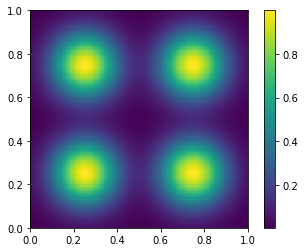

In [21]:
xs = np.linspace(-0,1,100)
ys = np.linspace(1,0,100) # in images the y axis is inverted
Xs,Ys = np.meshgrid(xs,ys)
zs=vegastest(np.array(list(zip(Xs.reshape(100*100),Ys.reshape(100*100)))).astype(np.float32)).reshape(100,100)

plt.imshow(zs, extent=[0,1,0,1])

plt.colorbar()
plt.show()

In [8]:
print("reset")
NF.create_model(n_pass_through=1,n_cells=1,n_bins=10, nn_width=2, NN=[20,20,20], roll_step=0)

w = torch.empty(10000, NF.n_flow, requires_grad=True)
torch.nn.init.uniform_(w,0,1)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w))
XJ = NF.model(NF.format_input(w))

                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian
X = ((XJ[:, :-1]).detach())
print("X")
print(X)
print("diff")
print(X[:,0]-w[:,1])
print("f(x)")
print(sin(X))

print("fXJ")
print(torch.mul(sin(X), XJ[:, -1]))
print(NF.dkl)

reset


TypeError: create_model() missing 1 required keyword-only argument: 'dev'

In [ ]:
"""
#a4=fig.add_subplot(143)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax.title.set_text('Jacobian after training')
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


NF.create_model(n_pass_through=1,n_cells=1, nn_width=2, NN=[5], roll_step=1)
rcParams['axes.labelpad'] = 800
z = torch.empty((10000,2)) 
torch.nn.init.uniform_(z,0,1)

w=NF.format_input(z)
X=NF.model(w).data.numpy()
fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
ax1.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax1.title.set_text('Jacobian before training')
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)
#ax1.auto_scale_xyz([0.5, 2], [0, 1], [1.55, 1.75])
ax1.xaxis._axinfo['label']['space_factor'] = 4.8
ax1.zaxis._axinfo['label']['space_factor'] = 8.8
rcParams['axes.labelpad'] = 80

print("\n")
"""

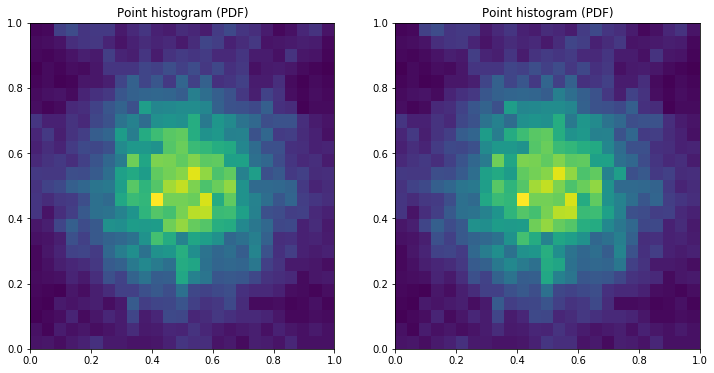

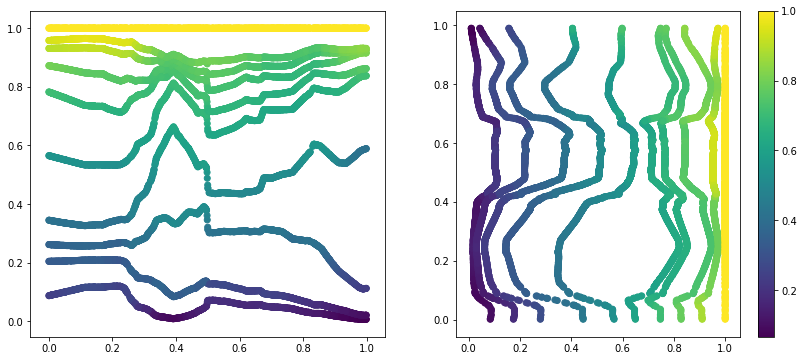

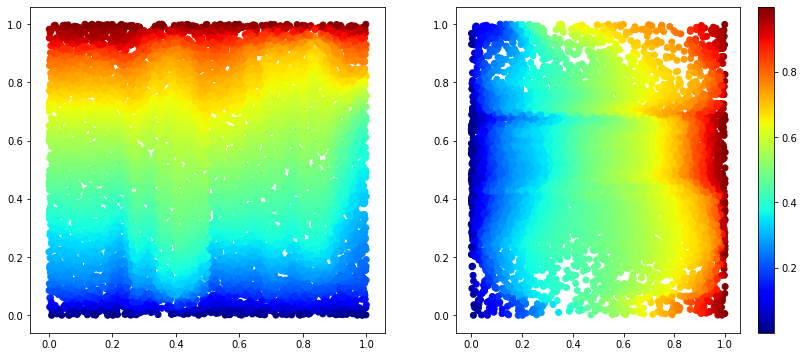

In [7]:
n_flow=4
w = torch.empty((20000,n_flow)) 
torch.nn.init.uniform_(w,0,1)
#q = torch.empty((12100,2)) 
#torch.nn.init.normal_(q,std=10)
#z=150*torch.tan((w-0.5)*(np.pi))
NF.create_model(n_cells=2, n_bins=10, NN=[11,11,11],dev=torch.device("cpu"))
model=torch.load('/home/niklas/Desktop/Thesis_code/Storage_runs/3105_mfrun_32/mfruns8/NIS/64/torch',map_location=torch.device('cpu'))
#NF.best_model.load_state_dict(model['model_state_dict'])
#model=NF.best_model
Y=NF.format_input(w, dev=torch.device("cpu"))
X=NF.model(Y)
XZ=NF.best_model(Y)

X=X.data.numpy()
XX=XZ.data.numpy()

fig = plt.figure(figsize=(12, 6))
a3=fig.add_subplot(121)

plt.hist2d(XX[:,0],XX[:,1],bins=25)
axes = plt.gca()
axes.set_xlim([-0,1]) 
axes.set_ylim([-0,1])


a3.title.set_text('Point histogram (PDF)')
a3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


#
a4=fig.add_subplot(122)

plt.hist2d(XX[:,0],XX[:,1],bins=25)
axes = plt.gca()
axes.set_xlim([-0,1])
axes.set_ylim([-0,1])


a4.title.set_text('Point histogram (PDF)')
a4.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


fig = plt.figure(figsize=(14, 6))
a5=fig.add_subplot(121)


w = torch.empty((1000,n_flow)) 
torch.nn.init.uniform_(w,0,1)
for idx, m in enumerate(NF.model.named_children()):
        if(m[0]=='0'):
            Z=m[1].NN(w[:,:1])
            
            W=Z[:,:,m[1].n_bins+1:]
           
            W=torch.exp(W)
        
            Wsum = torch.cumsum(W, axis=-1) 
        
            Wnorms = torch.unsqueeze(Wsum[:, :, -1], axis=-1) 
            
            
            W = W/Wnorms
            Wsum=Wsum/Wnorms
            V=Z[:,:,:m[1].n_bins+1]
            V=torch.exp(V)
        
            Vsum=torch.cumsum(V, axis=-1)


            Vnorms=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)

            Vnorms_tot=Vnorms[:, :, -1].clone() 
            V=torch.div(V,torch.unsqueeze(Vnorms_tot,axis=-1)) 
            VW=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)
            VW=torch.transpose(VW,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
           
            Wsum=torch.transpose(Wsum,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
            
            coords=np.stack([w[:,0].numpy() for 
                             _ in range(m[1].n_bins)], axis=0).reshape(w.shape[0]*m[1].n_bins,-1)
            
                
            
            
            plt.scatter(coords,torch.squeeze(Wsum,-1).detach().numpy(),c=torch.squeeze(VW,-1).detach().numpy())
            
            w2=m[1](NF.format_input(w,torch.device("cpu")))
      
        
        if(m[0]=='1'):
            a6=fig.add_subplot(122)
            
        
            Z=m[1].NN(torch.unsqueeze(w2[:,1],-1))
            
            W=Z[:,:,m[1].n_bins+1:]
            W=torch.exp(W)
            w2=w2.detach()
            Wsum = torch.cumsum(W, axis=-1) 
        
            Wnorms = torch.unsqueeze(Wsum[:, :, -1], axis=-1) 
            
            
            W = W/Wnorms
            Wsum=Wsum/Wnorms
            
            Wsum=torch.transpose(Wsum,0,2).reshape(m[1].n_bins*w2.shape[0],1,-1)
            V=Z[:,:,:m[1].n_bins+1]
            V=torch.exp(V)
        
            Vsum=torch.cumsum(V, axis=-1)


            Vnorms=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)

            Vnorms_tot=Vnorms[:, :, -1].clone() 
            V=torch.div(V,torch.unsqueeze(Vnorms_tot,axis=-1)) 
            VW=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)
            VW=torch.transpose(VW,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
            coords=np.stack([w2[:,1].numpy() for _ in range(m[1].n_bins)], axis=0)  
            
            plt.scatter(torch.squeeze(Wsum,-1).detach().numpy(), coords, c=torch.squeeze(VW,-1).detach().numpy())

plt.colorbar()


fig = plt.figure(figsize=(14, 6))
a7=fig.add_subplot(121)

w = torch.empty((10000,2)) 
torch.nn.init.uniform_(w,0,1)
for idx, m in enumerate(NF.model.named_children()):
        if(m[0]=='0'):
            
           
            
            plt.scatter(torch.unsqueeze(w[:,0],-1).detach().numpy(),torch.unsqueeze(w[:,1],-1).detach().numpy(),
                                c=torch.unsqueeze(m[1](NF.format_input(w,torch.device("cpu")))[:,1],-1).detach().numpy(),cmap='jet')
            
            w2=m[1](NF.format_input(w,torch.device("cpu")))
            w2=torch.cat((torch.roll(w2[:, :-1], 1, dims=-1), w2[:, -1:]), axis=-1)
        
        if(m[0]=='1'):
            a8=fig.add_subplot(122)
            q=m[1](NF.format_input(w2,torch.device("cpu")))
            c=torch.cat((torch.roll(q[:, :-1], 1, dims=-1), q[:, -1:]), axis=-1)
        
            plt.scatter(torch.unsqueeze(w2[:,1],-1).detach().numpy(),torch.unsqueeze(w2[:,0],-1).detach().numpy(),
                                c=torch.unsqueeze(q[:,1],-1).detach().numpy(),cmap='jet')
plt.colorbar()


In [4]:
w = torch.empty(20, 2)
torch.nn.init.normal_(w, std=100)
w.device

device(type='cpu')

In [25]:
f=camel
w = torch.empty(80000, NF.n_flow)
torch.nn.init.uniform_(w)
XJ = NF.best_model(NF.format_input(w,dev=torch.device("cpu")))
X = (XJ[:, :-1])
fXJ = torch.mul(f(X), XJ[:, -1])
loss = torch.mean(fXJ**2)
print(loss)


tensor(0.0782, grad_fn=<MeanBackward0>)


In [53]:

ngrid=40
f=create_funv(8,0.1)

start_time=datetime.datetime.utcnow()
m = vegas.AdaptiveMap([[0, 1]]*4, ninc=ngrid)


ny = np.int(30000*np.sqrt(2))
y = np.random.uniform(0., 1., (ny, 4))  # 300 000 random y's

x = np.empty(y.shape, float)            # work space
jac = np.empty(y.shape[0], float)
f2 = np.empty(y.shape[0], float)
loss_int=0
for j in range(ny): 
    loss_int+=f(y[j])**2/ny
print(loss_int)


for itn in range(10):                    # 10 iterations to adapt
    m.map(y, x, jac)                     # compute x's and jac
    loss=0
    for j in range(ny):                  # compute training data
        f2[j] = (jac[j] * f(x[j])) ** 2

    loss=np.mean(f2)
    print(loss)
    m.add_training_data(y, f2)           # adapt
    m.adapt(alpha=1)

    

m.map(y, x, jac)                     # compute x's and jac
loss=0
for j in range(ny):                  # compute training data
    f2[j] = (jac[j] * f(x[j])) ** 2

loss=np.mean(f2)
end_time=datetime.datetime.utcnow()


m.show_grid(ngrid,[[0,1]])
#m.show_grid(ngrid, [[0,2]])
#m.show_grid(ngrid,[[0,3]])
#m.show_grid(ngrid,[[1,2]])
#m.show_grid(ngrid,[[1,3]])
#m.show_grid(ngrid,[[2,3]])
lossrel=loss/loss_int
print("LOSSREL")
print(lossrel)
print("Time")
print((end_time-start_time).total_seconds())
print("loss")
print(loss)

0.0019022155244321941
0.0019022155244322264


KeyboardInterrupt: 

[[0, 1], [0, 1]]


tensor([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 1]], dtype=torch.int32)
tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1], dtype=torch.int32)
tensor([[ 4],
        [ 5],
        [ 6],
        [ 7],
        [12],
        [13],
        [14],
        [15]])


TypeError: new(): data must be a sequence (got float)

OSError: [Errno 12] Cannot allocate memory

0.3786308992605295
0.37863089926053145
0.36897120772145997
0.3661678139503569
0.36532176317649523
0.36504817773936704
0.36494973093980576
0.3649090527190579
0.36488964825140496
0.364879212264055
0.3648730996024868
0.9636643504666106
0.963654344127749


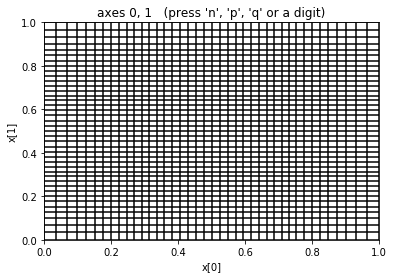

ValueError: bad directions: (0, 2)

In [7]:

n_flow=2
ngrid=40
f=create_funv(2,0.35)
#f=camelveg
start_time=datetime.datetime.utcnow()
m = vegas.AdaptiveMap([[0, 1]]*n_flow, ninc=ngrid)


#we gave NIS 3 000 000 evaluations -> 10 iterations * 300000 y's  ... 5 iterations till adaption
ny = np.int(30000*np.sqrt(4))
y = np.random.uniform(0., 1., (ny, n_flow))  # 300 000 random y's

x = np.empty(y.shape, float)            # work space
jac = np.empty(y.shape[0], float)
f2 = np.empty(y.shape[0], float)
loss_int=0
for j in range(ny): 
    loss_int+=f(y[j])**2/ny
print(loss_int)

min_loss=1000
for itn in range(10):                    # 10 iterations to adapt
    m.map(y, x, jac)                     # compute x's and ja
    loss=0
    for j in range(ny):                  # compute training data
        f2[j] = (jac[j] * f(x[j])) ** 2

    loss=np.mean(f2)
    if loss<min_loss:
        min_loss=loss
        mapper=copy.deepcopy(m)
    
    print(loss)
    m.add_training_data(y, f2)           # adapt
    m.adapt(alpha=1)

mapper.map(y, x, jac)                     # compute x's and jac
loss=0
for j in range(ny):                  # compute training data
    f2[j] = (jac[j] * f(x[j])) ** 2

loss=np.mean(f2)
end_time=datetime.datetime.utcnow()
print(loss/loss_int)


m.map(y, x, jac)                     # compute x's and jac
loss=0
for j in range(ny):                  # compute training data
    f2[j] = (jac[j] * f(x[j])) ** 2

loss=np.mean(f2)
end_time=datetime.datetime.utcnow()
print(loss/loss_int)

mapper.show_grid(ngrid,[[0,1]])
mapper.show_grid(ngrid, [[0,2]])
mapper.show_grid(ngrid,[[0,3]])
mapper.show_grid(ngrid,[[1,2]])
mapper.show_grid(ngrid,[[1,3]])
mapper.show_grid(ngrid,[[2,3]])


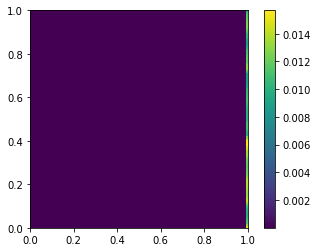

In [41]:
f=phase_spawn
xs = np.linspace(-0,1,100)
ys = np.linspace(1,0,100) # in images the y axis is inverted
Xs,Ys = np.meshgrid(xs,ys)
points=np.array(list(zip(Xs.reshape(100*100),Ys.reshape(100*100)))).astype(np.float32)
t=torch.tensor(points, dtype=torch.double)

Y=NF.model(NF.format_input(t,dev=t.device))

zs=(f(Y[:,:-1])*Y[:,-1]).reshape(100,100)

plt.imshow(zs.detach(), extent=[0,1,0,1])

plt.colorbar()
plt.show()



1.1257342474511578e-21
1.1257342474511439e-21
5.25741004368618e-20
1.2686323938003016e-26
2.7735998205906503e-24
1.2646285646910181e-20
1.1154890216541778e-23
4.069241257659171e-22
1.1715198808378845e-22
2.255394000967253e-20
3.469885719654011e-21
8.377717042670301e-24
1.1604218682182498e-21
6.829624796239942e-21
1.1672849032477853e-22
3.525397858417742e-21
1.656957565074171e-22
1.5551022067504526e-20
7.20383388049418e-22
1.0122549251707517e-21
9.538139877862752e-22
1.1269377267971442e-05
0.0740179369077778
--------
1.1257137736208421e-21
8.325399862583853e-23
0.07395663140733655


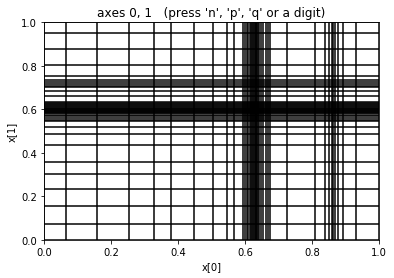

'\n0.00028052061253690404\n--------\n8.790010900950007e-22\n1.2278332076980025e-25\n0.00013968506086440698\n'

In [6]:
n_flow=32
ngrid=40
def vegas_phase(x):
    x=torch.tensor(x).unsqueeze(0)
    return phase_spawn(x).detach().numpy()
f=create_funv(8,0.25)
start_time=datetime.datetime.utcnow()
m = vegas.AdaptiveMap([[0, 1]]*n_flow, ninc=ngrid)

#m.show_grid(ngrid,axes=[[2,1],[0,2],[0,3],[1,2],[1,3],[2,3]])
#we gave NIS 3 000 000 evaluations -> 10 iterations * 300000 y's  ... 5 iterations till adaption
ny = np.int(100000)
y = np.random.uniform(0., 1., (ny, n_flow))  # 300 000 random y's

x = np.empty(y.shape, float)            # work space
jac = np.empty(y.shape[0], float)
f2 = np.empty(y.shape[0], float)
fv1 = np.empty(y.shape[0], float)
fv2 = np.empty(y.shape[0], float)
loss_int=0
for j in range(ny): 
    loss_int+=f(y[j])**2/ny
print(loss_int)

min_loss=1000
for itn in range(20):                    # 10 iterations to adapt
    m.map(y, x, jac)                     # compute x's and ja
    loss=0
    for j in range(ny):                  # compute training data
        f2[j] = (jac[j] * f(x[j])) ** 2

    loss=np.mean(f2)
    if loss<min_loss:
        min_loss=loss
        mapper=copy.deepcopy(m)
    
    print(loss)
    m.add_training_data(y, f2)           # adapt
    m.adapt(alpha=1)

    
mapper.map(y, x, jac)                     # compute x's and jac
loss=0
for j in range(ny):                  # compute training data
    f2[j] = (jac[j] * f(x[j])) ** 2

loss=np.mean(f2)
end_time=datetime.datetime.utcnow()
print(loss/loss_int)


m.map(y, x, jac)                     # compute x's and jac
loss=0
for j in range(ny):                  # compute training data
    f2[j] = (jac[j] * f(x[j])) ** 2
for j in range(ny):                  # compute training data
    fv2[j] = (jac[j] * f(x[j]))
for j in range(ny):                  # compute training data
    fv1[j] = (f(y[j]))


loss=np.mean(f2)
end_time=datetime.datetime.utcnow()
print(loss/loss_int)
print("--------")
print(np.var(fv1))
print(np.var(fv2))
print(np.var(fv2)/np.var(fv1))
mapper.show_grid(ngrid,[[0,1]])

#8/25; 32; 200,000 x 20: just no stable improvement; test with 1 peak, test with higher number of single eval
"""
0.00028052061253690404
--------
8.790010900950007e-22
1.2278332076980025e-25
0.00013968506086440698
"""
#-> had optimal in 3rd iteration, but got stable only after like 12th

Subclass
<class '__main__.A'>
True
<class '__main__.B'>
True
<class '__main__.C'>
True
Torch ptype propagation
<class 'torch.Tensor'>
True
<class 'torch.Tensor'>
True
Indexing [None, elipsis, integer, slice
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
bool
tensor([False, False, False])


tensor([[nan, nan, nan, nan, nan, nan, nan]])
(3.186632003925094e-17+0.5204164998665332j)


In [8]:
n_flow=4
f=create_fun(8,0.25)
fv=create_funv(8,0.25)
NF =  PWQuadManager(n_flow=n_flow)
NF.create_model(n_cells=4, n_bins=4, NN=[16]*8,dev=torch.device("cpu"))
model=torch.load('/home/niklas/Desktop/Thesis_code/Storage_runs/mfrun_full/NIS/43435/torch',map_location=torch.device('cpu'))
NF.best_model.load_state_dict(model['model_state_dict'])

w = torch.empty((50000,n_flow)) 
torch.nn.init.uniform_(w,0,1)
#q = torch.empty((12100,2)) 
#torch.nn.init.normal_(q,std=10)
#z=150*torch.tan((w-0.5)*(np.pi))
#model=torch.load('/home/niklas/Desktop/Thesis_code/Storage_runs/3105_mfrun_32/mfruns8/NIS/64/torch',map_location=torch.device('cpu'))
#NF.best_model.load_state_dict(model['model_state_dict'])
#model=NF.best_model
Y=NF.format_input(w, dev=torch.device("cpu"))
XZ=NF.best_model(Y)
int1=torch.mean(f(Y[:,:-1])*Y[:,-1])
print(int1)
err1=torch.std(f(Y[:,:-1])*Y[:,-1])/math.sqrt(50000)
print(err1)
integ = vegas.Integrator([[0, 1], [0, 1], [0, 1], [0, 1]])

result = integ(fv, nitn=10, neval=5000)
print(result)

tensor(0.2226)
tensor(0.0009)
0.22275(44)


In [8]:
for t in range(1):
    print("!")

!


In [8]:
np.mean([1.2324e-07, 3.6234e-06, 3.0862e-07, 1.0058e-08, 4.1442e-08, 3.1408e-08,
        1.9680e-07, 9.7042e-08, 1.1267e-07, 6.4244e-08, 2.4379e-07, 2.4728e-07,
        1.6931e-07, 7.7310e-08, 3.8458e-08, 8.5725e-08, 1.4684e-07, 1.7259e-07,
        5.6029e-08, 2.2755e-07, 1.2193e-07, 1.8199e-07, 3.5604e-08, 1.1648e-07,
        2.1759e-07, 3.2649e-08, 2.3432e-07, 7.2173e-08, 1.5718e-07, 2.4548e-07,
        1.5542e-07, 9.1470e-08, 1.3454e-07, 3.7597e-08, 1.6794e-07, 6.8394e-08,
        1.9161e-08, 4.1590e-08, 1.5658e-07, 6.6991e-08, 1.1413e-07, 1.0572e-07,
        5.8930e-08, 1.0864e-07, 1.2108e-07, 1.2320e-07, 1.3787e-07, 1.9790e-08,
        9.0859e-08, 1.0844e-07, 1.3073e-07, 2.1863e-07])

1.8782507692307696e-07

In [9]:
np.mean([ 2.0785e-07, 1.7799e-07,
        2.8216e-06, 9.2461e-07, 1.6572e-06, 1.0869e-05, 3.9982e-06, 4.4656e-06,
        1.6538e-07, 6.7147e-04, 3.7479e-06, 1.4121e-06, 4.3233e-06, 3.4947e-08,
        2.5969e-06, 1.9689e-05, 2.9060e-06, 1.0009e-07, 2.6433e-07, 9.8489e-05,
        1.7890e-07, 7.8522e-07, 1.2356e-07, 1.6066e-07, 4.5711e-07, 9.6241e-08,
        6.5171e-07, 4.8774e-07, 3.9006e-05, 2.1623e-06, 4.8532e-06, 3.6008e-07,
        4.2254e-08, 7.0262e-07, 2.2821e-06, 3.3110e-07, 5.0168e-07, 2.9353e-05,
        7.5464e-06, 1.1192e-06, 3.2452e-07, 1.4713e-07, 6.5710e-06, 1.2603e-07,
        2.3584e-07, 1.6340e-07, 1.4795e-07, 1.3498e-07, 7.8440e-07, 4.2076e-06,
        2.5137e-08, 5.9543e-07, 1.6484e-05, 2.1806e-06, 3.2710e-06, 2.2262e-05,
        5.6457e-06, 1.0854e-06, 6.0568e-08, 2.9969e-07, 2.3975e-07, 6.6313e-07,
        8.3158e-08, 3.2668e-06, 2.9023e-05, 6.0183e-06, 3.2635e-07, 7.7915e-08,
        5.1684e-06, 3.8903e-07, 1.2679e-06, 1.7975e-07, 3.9403e-07, 1.8654e-05,
        5.5935e-08, 1.7027e-06, 3.5814e-07, 5.3323e-07, 2.6280e-06, 2.6500e-06,
        4.1231e-07, 1.3528e-06, 2.3755e-07, 1.7660e-08, 4.2910e-07, 8.0605e-08,
        9.1614e-07, 2.8730e-07, 7.9203e-06, 9.3772e-06, 2.6518e-05, 1.5515e-04,
        2.8023e-07, 1.1581e-04, 4.7255e-07, 1.3710e-06, 2.3576e-06, 1.7232e-06,
        3.1322e-07])

1.398970434343434e-05

In [15]:
global c
print(c)
c=0
print(c)
def f(x):
    try:
        1/0
    except:
        x=x+1
        global c
        c=c+1
    return x
f(2)
print(c)
f(5)
print(c)


1
0
1
2


In [13]:
fv=create_funv(2,0.25)
neval=5000
nitn=25
var_n=40000
w = torch.empty(50000, NF.n_flow)
torch.nn.init.uniform_(w)
f=create_fun(2,0.25)
integv=vegas.Integrator([[0, 1]]*n_flow)
var_old=torch.var(f(w))
integv(fv, nitn=5, neval=neval)
result = integv(fv, nitn=nitn, neval=neval)
sig=result.mean/(2.5681894616*10**(-9))
sig_err=result.sdev/(2.5681894616*10**(-9))
m = vegas.AdaptiveMap(integv.map)


y = np.random.uniform(0., 1., (var_n, n_flow)) 
x = np.empty(y.shape, float)           
jac = np.empty(y.shape[0], float)
f2 = np.empty(y.shape[0], float)

m.map(y, x, jac)  
for i in range(var_n):
    f2[i] = (jac[i] * fv(x[i]))
v_var=np.var(f2)
w_max=np.max(f2)
w_mean=np.mean(f2)
print(var_old)
print(v_var)

tensor(0.0146)
0.011164618049107837
